In [110]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler, MaxAbsScaler
from sklearn.decomposition import IncrementalPCA, PCA

from sklearn.base import BaseEstimator, TransformerMixin

from frog.flow_reconstruction import FlowReconstruction
from frog.normalization import SliceMinMaxScaler, SliceMaxAbsScaler
from frog.transformers import IdentityTransformer, MeanCentering, SliceMeanCentering

import xarray as xr
import numpy as np

from sklearn.metrics import r2_score

import time
from sklearn.pipeline import Pipeline
from sklearn.decomposition import IncrementalPCA
from sklearn.preprocessing import MaxAbsScaler
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel
from sklearn.metrics import r2_score, root_mean_squared_error

def nrmse(y_true, y_pred, normalization='range'):
    """
    Calcula o Normalized Root Mean Squared Error (NRMSE).

    Parâmetros:
    y_true : array-like
        Valores verdadeiros.
    y_pred : array-like
        Valores previstos pelo modelo.
    normalization : str, opcional (padrão='range')
        Método de normalização. Opções: 'range' ou 'mean'.
    
    Retorna:
    float
        O valor do NRMSE.
    """
    # Garante que os inputs são arrays numpy
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)

    rmse = root_mean_squared_error(y_true, y_pred)
    
    if normalization == 'range':
        denominator = np.max(y_true) - np.min(y_true)
    elif normalization == 'mean':
        denominator = np.mean(y_true)
    else:
        raise ValueError("O método de normalização deve ser 'range' ou 'mean'.")
        
    if denominator == 0:
        # Evita divisão por zero se todos os valores de y_true forem iguais
        return np.inf

    return rmse / denominator

def train_model(data_train, data_test, n_components_X=5, n_components_y=5, save_file=None):
    X_train, y_train = data_train
    X_test, y_test = data_test

    y_rom = Pipeline([
        ('scaler', MaxAbsScaler()), 
        ('reducer', IncrementalPCA(n_components=n_components_y))
    ])
    
    X_rom = Pipeline([
        ('scaler', MaxAbsScaler()), 
        ('reducer', IncrementalPCA(n_components=n_components_X))
    ])


    model = FlowReconstruction(
        X_rom=X_rom,
        y_rom=y_rom,
        surrogate=Pipeline([
            ('regressor', GaussianProcessRegressor(
                kernel=ConstantKernel(1.0, (1e-2, 1e2)) * RBF(
                    length_scale=[1.0] * n_components_X, 
                    length_scale_bounds=(1e-3, 1e3)
                ),
                n_restarts_optimizer=50,
                normalize_y=False,
                alpha=0.001,
                random_state=42
            ))
        ]),
        surrogate_kwargs={}
    )

    # Início da contagem de tempo
    start_time = time.time()
    
    model.fit(X=X_train, y=y_train)
    
    # Fim da contagem de tempo
    end_time = time.time()
    elapsed_time = end_time - start_time

    prediction = model.predict(X_test)

    r2 = r2_score(y_test.flatten(), prediction.flatten())
    nrmse_value = nrmse(y_test, prediction, normalization='range')
    eps = 1e-10
    max_relative_error = np.max(np.abs((y_test - prediction) / (y_test + eps)))  # Pequeno valor para evitar divisão por zero
    max_abs_error = np.max(np.abs(y_test - prediction))

    print(f"Training completed")
    print(f"R2 Score: {r2:.6f}")
    print(f"NRMSE: {nrmse_value:.6f}")
    print(f"Max Relative Error: {max_relative_error:.6f}")
    print(f"Max Absolute Error: {max_abs_error:.6f}")
    print(f"Training time: {elapsed_time:.2f} seconds")

    if save_file is not None:
        print(f"Saving model to {save_file}")
        model.save(save_file)

    return model

In [111]:
data_type = 'hdf5'  # 'hdf5' or 'xarray'

ntrain=145
nvalidation = ntrain+18
ntest = nvalidation+18

X_variable=['p.txt', 'T.txt', 'M.txt']
y_variable=['Pressure', 'Temperature', 'Mach', 'Heat_Flux']
if data_type == 'hdf5':
    from data_handler import dataHandler


    bc = dataHandler(
        '../data/Q1D.hdf5', 
        ['p0in', 'T0in'])

    lfd = dataHandler(
        '../data/Q1D.hdf5', 
        X_variable)

    hfd = dataHandler(
        '../data/SU2_fluid.hdf5',
        y_variable)

    
    X_train = lfd.data[:,:ntrain].T
    y_train = hfd.data[:,:ntrain].T
    bc_train = bc.data[:,:ntrain].T

    X_validation = lfd.data[:,ntrain:nvalidation].T
    y_validation = hfd.data[:,ntrain:nvalidation].T
    bc_validation = bc.data[:,ntrain:nvalidation].T

    X_test = lfd.data[:,nvalidation:ntest].T
    y_test = hfd.data[:,nvalidation:ntest].T
    bc_test = bc.data[:,nvalidation:ntest].T

elif data_type == 'xarray':
    from data_handler import dataHandler
    import xarray as xr
    import numpy as np

    bc = dataHandler(
        '../data/Q1D.hdf5', 
        ['p0in', 'T0in'])

    lfd = dataHandler(
        '../data/Q1D.hdf5', 
        X_variable)

    hfd = dataHandler(
        '../data/SU2_fluid.hdf5',
        y_variable)

    lfd_data = xr.open_dataset("../data/Q1D.nc")
    lfd_data = lfd_data[X_variable].to_array().values  # Flatten the first two dimensions
    lfd_data = lfd_data.reshape(-1, lfd_data.shape[-1])

    hfd_data = xr.open_dataset("../data/SU2_fluid.nc")
    data_list = []
    for var in y_variable:
        data = hfd_data[[var]].to_array().values
        data_list.append(data.reshape(-1, data.shape[-1]))
    hfd_data = np.vstack(data_list)

    bc_data = xr.open_dataset("../data/SU2_fluid.nc")
    bc_data = bc_data[['p0in', 'T0in']].to_array().values
    bc_data = bc_data.reshape(-1, bc_data.shape[-1])

    X_train = lfd_data[:,:ntrain].T
    y_train = hfd_data[:,:ntrain].T
    bc_train = bc_data[:,:ntrain].T

    X_validation = lfd_data[:,ntrain:nvalidation].T
    y_validation = hfd_data[:,ntrain:nvalidation].T
    bc_validation = bc_data[:,ntrain:nvalidation].T

    X_test = lfd_data[:,nvalidation:ntest].T
    y_test = hfd_data[:,nvalidation:ntest].T
    bc_test = bc_data[:,nvalidation:ntest].T

elif data_type == 'xarray2':
    from data_handler import split_dataset_named


    y_data_train, y_data_test, y_data_val = split_dataset_named(
        xr.open_dataset("../data/SU2_fluid.nc"),
        dim="phony_dim_1",
        frac=(0.80, 0.10, 0.10),
        seed=42,
        sort=False,
    )

    X_data_train, X_data_test, X_data_val = split_dataset_named(
        xr.open_dataset("../data/Q1D.nc"),
        dim="phony_dim_1",
        frac=(0.80, 0.10, 0.10),
        seed=42,
        sort=False
    )


    def to_array(dataset, variables):
        data_list = []
        for var in variables:
            data = dataset[[var]].to_array().values
            data_list.append(data.reshape(-1, data.shape[-1]))
        return np.vstack(data_list)
    
    X_train = to_array(X_data_train, X_variable).T
    y_train = to_array(y_data_train, y_variable).T
    bc_train = to_array(y_data_train, ['p0in', 'T0in']).T

    X_test = to_array(X_data_test, X_variable).T
    y_test = to_array(y_data_test, y_variable).T
    bc_test = to_array(y_data_train, ['p0in', 'T0in']).T

    X_validation = to_array(X_data_val, X_variable).T
    y_validation = to_array(y_data_val, y_variable).T
    bc_validation = to_array(y_data_train, ['p0in', 'T0in']).T
  

In [112]:
model = train_model(
    data_train=(X_train, y_train),  # Não utilizado, mas necessário para a assinatura da função
    data_test=(X_test, y_test),   # Não utilizado, mas necessário para a assinatura da função
    n_components_X=3,
    n_components_y=3,
    save_file="../data/gp_model"
)

Performing ROM fit on X data
Performing ROM fit on y data


Performing surrogate model fit


/Users/ppiper/micromamba/envs/plaid/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


Training completed
R2 Score: 1.000000
NRMSE: 0.000000
Max Relative Error: 0.055981
Max Absolute Error: 9157.806163
Training time: 5.70 seconds
Saving model to ../data/gp_model
Saved model to: ../data/gp_model


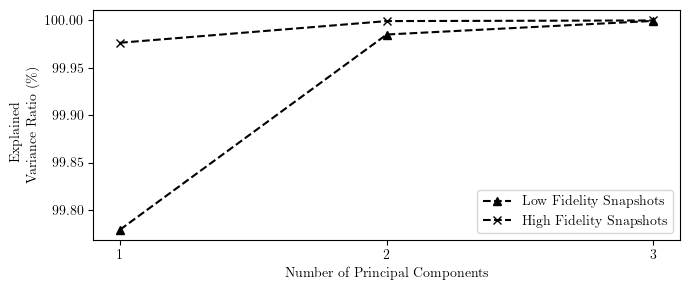

In [113]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import FormatStrFormatter

plt.rcParams['text.usetex'] = True
plt.rcParams['font.family'] = 'serif'
plt.figure(figsize=(7, 3))
# exemplo: fig, ax = plt.subplots()
ax = plt.gca()  # pega o eixo atual
ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))

lf_energy = np.cumsum(model.X_rom.named_steps['reducer'].explained_variance_ratio_)*100
x = np.arange(1, len(lf_energy)+1)
ax.plot(x,lf_energy, 
    ls='--', marker='^', label='Low Fidelity Snapshots', color='k')
hf_energy = np.cumsum(model.y_rom.named_steps['reducer'].explained_variance_ratio_)*100

ax.plot(x, hf_energy,
    ls='--', marker='x', label='High Fidelity Snapshots', color='k')
ax.set_xlabel(r"Number of Principal Components")
ax.set_ylabel(r"Explained \\ Variance Ratio (\%)")
ax.set_xticks(x)
ax.legend()
ax.figure.tight_layout()
ax.figure.savefig("../latex_src/Figuras/POD_energy.pdf")

In [114]:
prediction = model.predict(X_test)

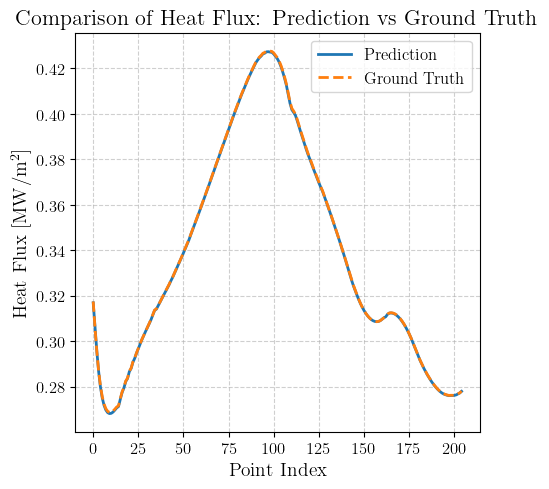

In [115]:
import matplotlib.pyplot as plt

plt.figure(figsize=(5,5))

# Plot prediction
plt.plot(prediction[0, hfd.indexes['Heat_Flux']][3:-2]/1e6, label=r'Prediction', color='tab:blue', linewidth=2)

# Plot ground truth
plt.plot(y_test[0, hfd.indexes['Heat_Flux']][3:-2]/1e6, label=r'Ground Truth', color='tab:orange', linewidth=2, linestyle='--')

# Title and labels with LaTeX
plt.title(r'Comparison of Heat Flux: Prediction vs Ground Truth', fontsize=16, fontweight='bold')
plt.xlabel(r'Point Index', fontsize=14)
plt.ylabel(r'Heat Flux [$\mathrm{MW/m^2}$]', fontsize=14)

# Grid and style
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.tight_layout()
plt.show()



In [116]:
def plot_ground_truth(mesh, vmin, vmax, sargs):
    import pyvista as pv
    plotter = pv.Plotter(window_size=(800,600))
    plotter.add_mesh(mesh, scalars='Ground-Truth', cmap='plasma', clim=(vmin, vmax), scalar_bar_args=sargs)
    plotter.add_mesh(mesh.contour(), color="black")
    plotter.view_xy()
    plotter.show()


def plot_rom(mesh, vmin, vmax, sargs):
    import pyvista as pv
    plotter = pv.Plotter(window_size=(800,600))
    plotter.add_mesh(mesh, scalars='ROM', cmap='plasma', clim=(vmin, vmax), scalar_bar_args=sargs)
    plotter.add_mesh(mesh.contour(), color="black")
    plotter.view_xy()
    plotter.show()


def plot_error_log(mesh, vmin, vmax, sargs):
    import pyvista as pv
    plotter = pv.Plotter(window_size=(800,600))
    plotter.add_mesh(mesh, scalars='Relative Error Log', cmap='inferno', clim=(vmin, vmax), scalar_bar_args=sargs)
    plotter.add_mesh(mesh.contour(), color="black")
    plotter.view_xy()
    plotter.show()


def plot_error_abs(mesh, vmin, vmax, sargs):
    import pyvista as pv
    plotter = pv.Plotter(window_size=(800,600))
    plotter.add_mesh(mesh, scalars='Absolute Error', cmap='inferno', clim=(vmin, vmax), scalar_bar_args=sargs)
    plotter.add_mesh(mesh.contour(), color="black")
    plotter.view_xy()
    plotter.show()


def plot_var(idx, variable, unit, scale=1):
    import pyvista as pv
    import numpy as np

    pv.set_jupyter_backend('static')

    meshfile = '../data/sample_runs/SU2/outputs/fluid.vtk'
    mesh = pv.read(meshfile)

    mesh['Ground-Truth'] = y_test[idx, hfd.indexes[f'{variable}']] * scale
    mesh['ROM'] = prediction[idx, hfd.indexes[f'{variable}']] * scale

    eps = 1e-3
    rel_error = np.abs(mesh['ROM'] - mesh['Ground-Truth']) / (np.abs(mesh['Ground-Truth']) + 1e-12)
    mesh['Relative Error Log'] = np.log10(rel_error + eps)

    abs_error = np.abs(mesh['ROM'] - mesh['Ground-Truth'])
    mesh['Absolute Error'] = abs_error

    vmin_err = mesh['Relative Error Log'].min()
    vmax_err = mesh['Relative Error Log'].max()

    vmin_abs_err = mesh['Absolute Error'].min()
    vmax_abs_err = mesh['Absolute Error'].max()

    vmin_common = min(mesh['Ground-Truth'].min(), mesh['ROM'].min())
    vmax_common = max(mesh['Ground-Truth'].max(), mesh['ROM'].max())

    sargs_template = dict(
        height=0.1,
        vertical=False,
        position_x=0.25,
        position_y=0.02,
        title_font_size=18,
        label_font_size=14,
        fmt="%.2f",
        n_labels=5,
    )
    sargs_gt = dict(**sargs_template, title=f"{variable} - Ground Truth {unit}")
    sargs_rom = dict(**sargs_template, title=f"{variable} - ROM {unit}")
    sargs_err = dict(**sargs_template, title=f"{variable} - Relative Error log10")
    sargs_abs_err = dict(**sargs_template, title=f"{variable} - Absolute Error {unit}")

    mesh_gt = mesh.copy()
    mesh_rom = mesh.copy()
    mesh_err = mesh.copy()
    mesh_abs_err = mesh.copy()

    # Agora chama os plots separados, passando mesh, limites e args
    plot_ground_truth(mesh_gt, vmin_common, vmax_common, sargs_gt)
    plot_rom(mesh_rom, vmin_common, vmax_common, sargs_rom)
    plot_error_log(mesh_err, vmin_err, vmax_err, sargs_err)
    plot_error_abs(mesh_err, vmin_abs_err, vmax_abs_err, sargs_abs_err)


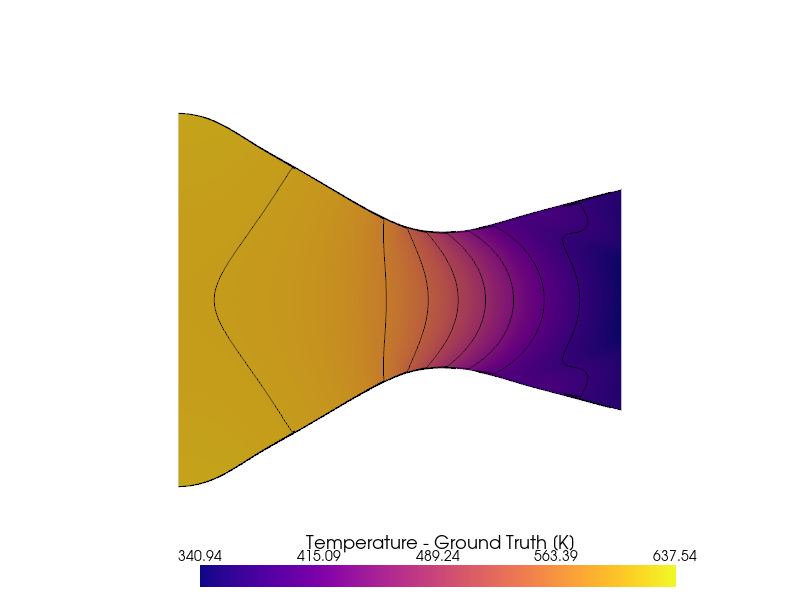

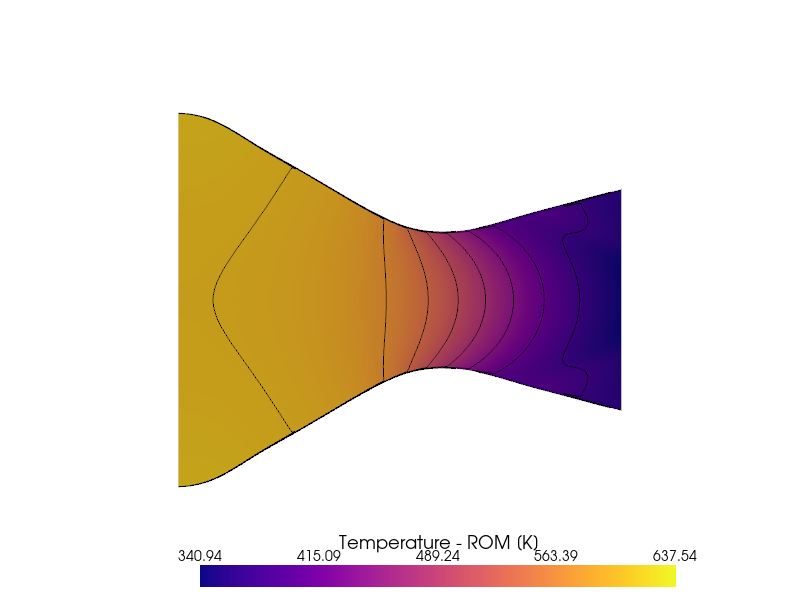

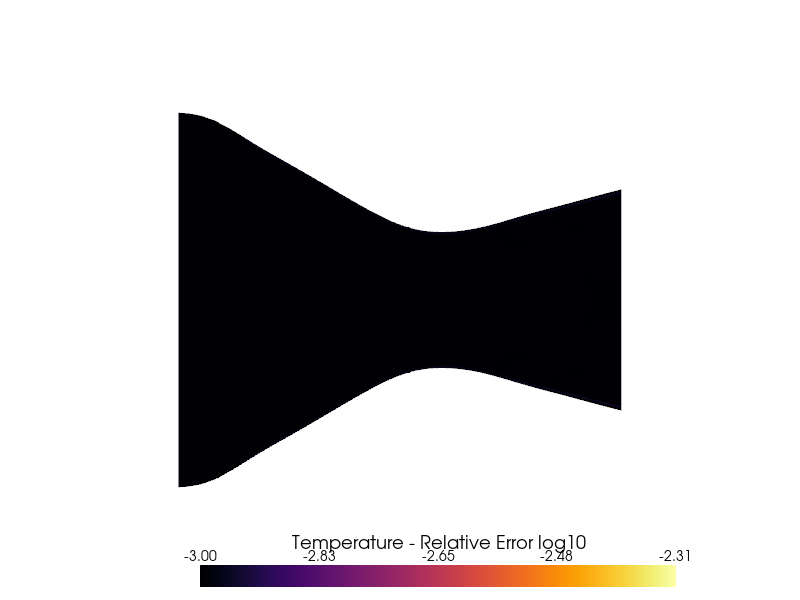

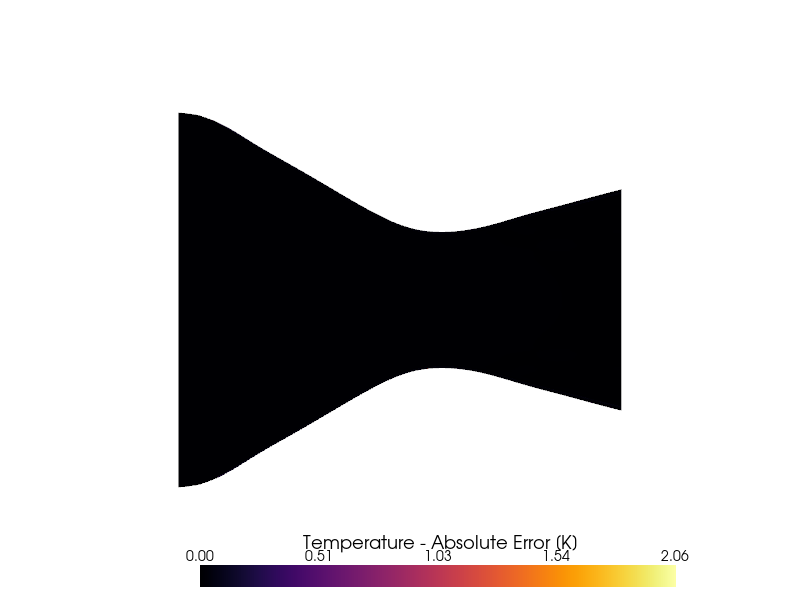

In [117]:
plot_var(0, 'Temperature', '[K]')

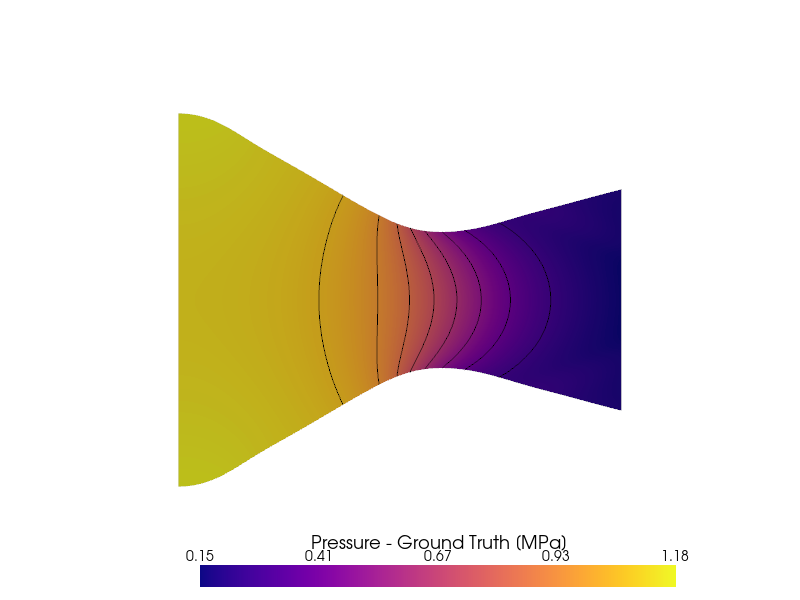

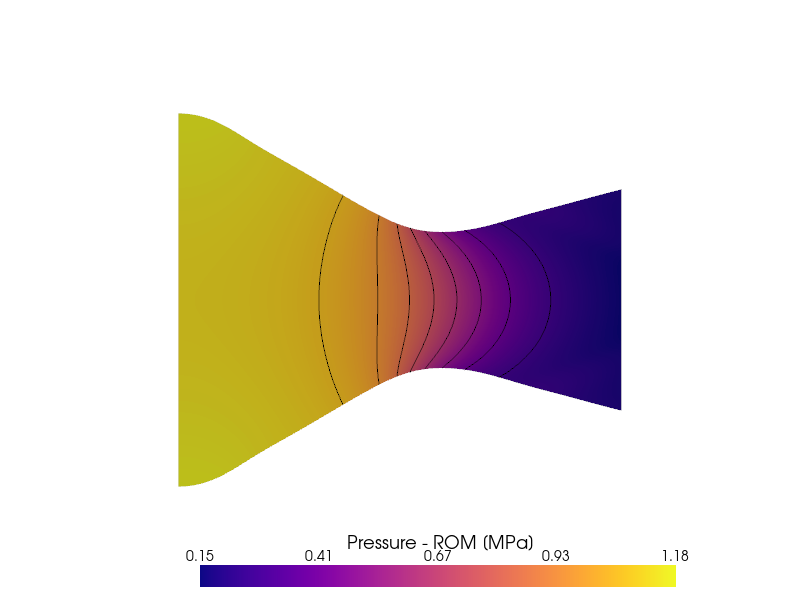

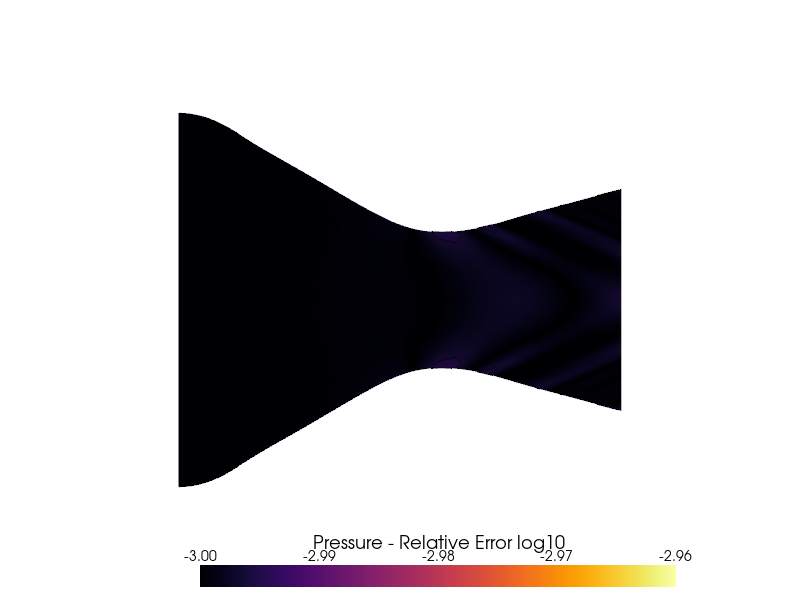

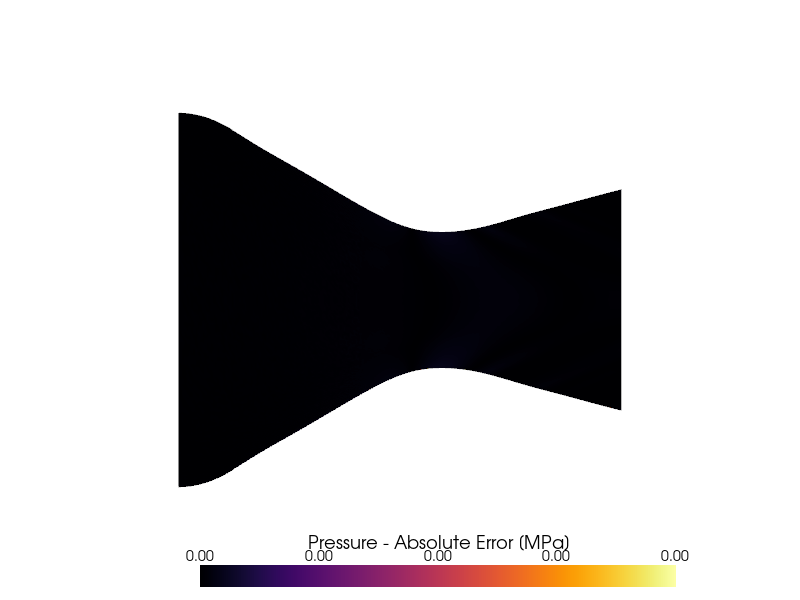

In [118]:
plot_var(0, 'Pressure', '[MPa]', 1e-6 )

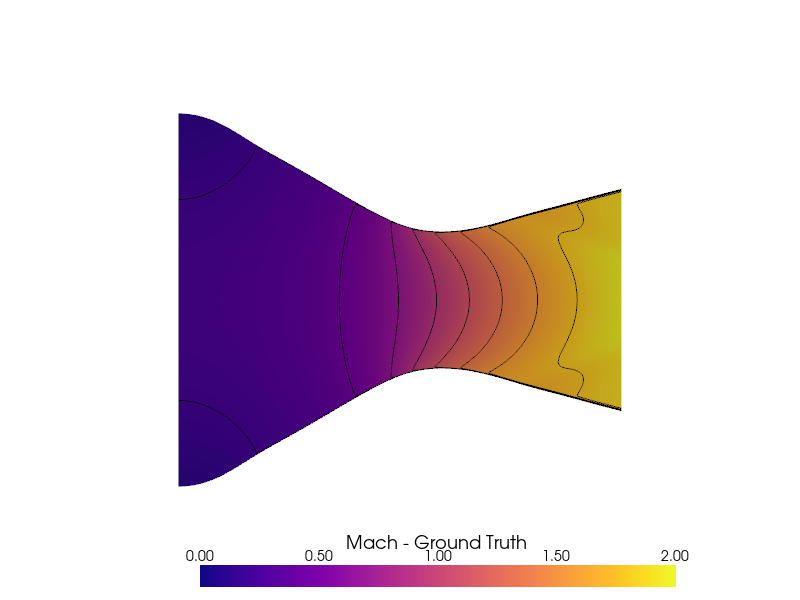

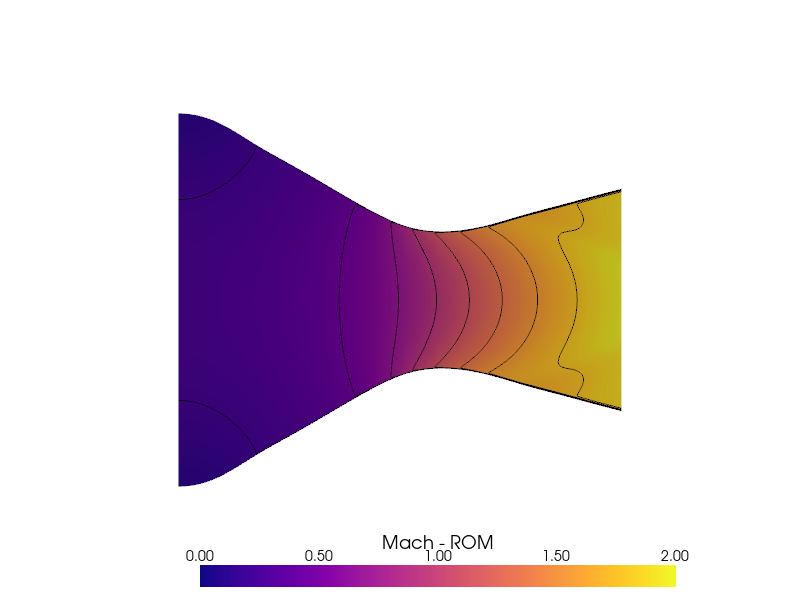

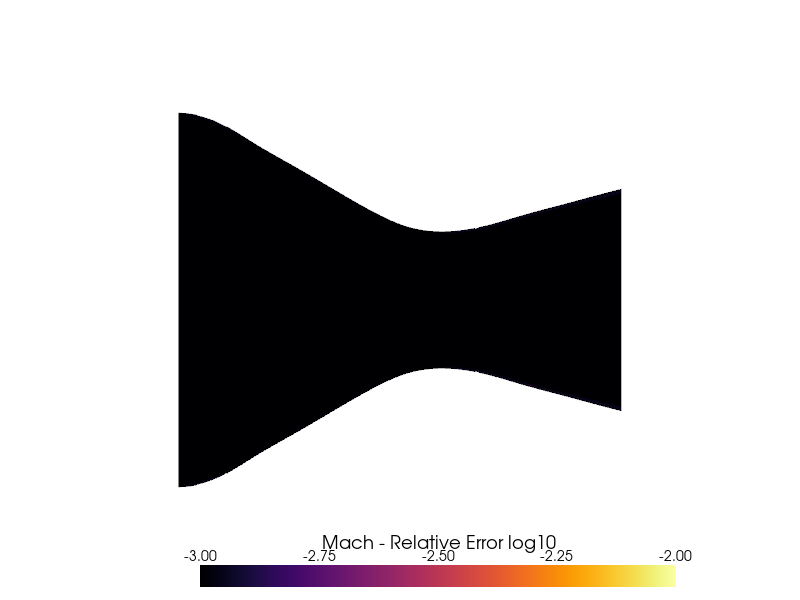

Context leak detected, msgtracer returned -1


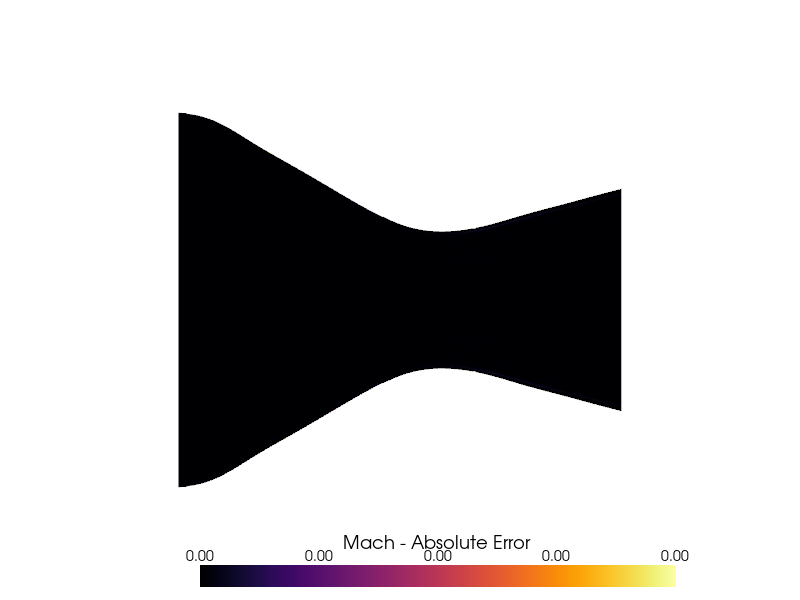

In [119]:
plot_var(0, 'Mach', '', 1 )